1. import libraries

In [16]:
#import 
%run 0_function.ipynb
# from function import yyplot_k, search_highly_correlated_variables_cv, boruta_cv

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from adjustText import adjust_text
from sklearn.linear_model import ARDRegression
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

2. Setting

In [17]:
#random seed
rseed_cv = 42
rseed_boruta = 1

In [18]:
#select dataset, monomer, descriptors, perc
train_data_set = "1&2" #1&2
test_data_set = "3&4" #3&4
monomer = "nBA" #nBA, St
descriptors = "mechanism_oriented" #mechanism_oriented
perc = 10 #nBA=10, St=100

3. Run model

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	5
Tentative: 	5
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	5
Tentative: 	5
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	5
Tentative: 	5
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	5
Tentative: 	5
Rejected: 	0
Iteration: 	12 / 100
Confirmed: 	6
Tentative: 	4
Rejected: 	0
Iteration: 	13 / 100
Confirmed: 	6
Tentative: 	4
Rejected: 	0
Iteration: 	14 / 100
Confirmed: 	6
Tentative: 	4
Rejected: 	0
Iteration: 	15 / 100
Confirmed: 	6
Tentative: 	4
Rejected: 	0
Iteration: 	16 / 100
Confirmed: 	7
Tentative: 	3
Rejected: 	0
Iteration:

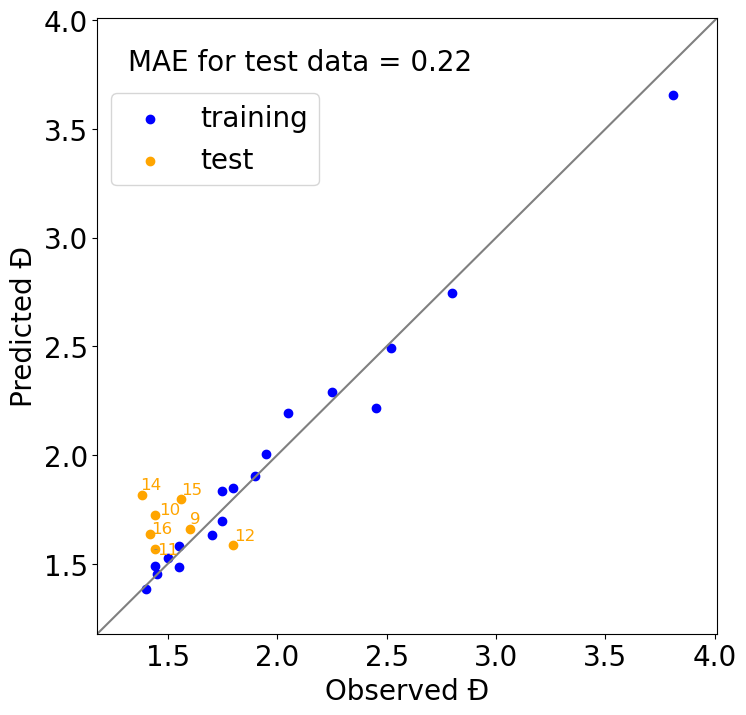

In [19]:
if __name__ == "__main__":
    # file & preprocessing
    try:     
        df_X = pd.read_excel("../data/XY/data_set_{}/data_set_{}_{}_descriptors.xlsx".format(train_data_set, train_data_set, descriptors), index_col = 0, sheet_name = monomer) #descriptors select
    except ValueError:
        print(f"Sheet '{monomer}' not found. Loading the first sheet instead.")
        df_X = pd.read_excel("./0_doctor_reserch/1_nitroxide/paper/sentence/github/data/XY/data_set_{}/data_set_{}_{}_descriptors.xlsx".format(train_data_set, train_data_set, descriptors), index_col = 0)
        
    df_Y = pd.read_excel("../data/XY/data_set_{}/data_set_{}_SMILES&objective_function.xlsx".format(train_data_set, train_data_set), index_col = 0)
    
    
    df = pd.concat([df_X, df_Y], axis=1)
    
    df.index = df.index.astype("str")
    df.drop(["41"], axis=0, inplace=True) #Select the sample you want to use
    X = df.iloc[:, :len(df_X.columns)]
 
    y = np.log(df["{}_PDI".format(monomer)]-1) # St_PDI or nBA_PDI
    
    fold = len(df.index)
    kf = KFold(n_splits=fold, shuffle=True, random_state=rseed_cv)
    
    model = ARDRegression(n_iter=1000)
       
    #train            
    X = search_highly_correlated_variables(X, 0.8)
    X = boruta(X, y, perc = perc, rseed_boruta = rseed_boruta)
    
    scaler_X = StandardScaler()
    scaler_X.fit(X)
    X_sc = pd.DataFrame(scaler_X.transform(X), index = X.index, columns = X.columns)
    
    model.fit(X_sc, y)
    y_pred = model.predict(X_sc)
            
    #test
    try:     
        df_test_X = pd.read_excel("../data/XY/data_set_{}/data_set_{}_{}_descriptors.xlsx".format(test_data_set, test_data_set, descriptors), index_col = 0, sheet_name = monomer) #descriptors select
    except ValueError:
        print(f"Sheet '{monomer}' not found. Loading the first sheet instead.")
        df_test_X = pd.read_excel("../data/XY/data_set_{}/data_set_{}_{}_descriptors.xlsx".format(test_data_set, test_data_set, descriptors), index_col = 0)
  
    df_test_Y = pd.read_excel("../data/XY/data_set_{}/data_set_{}_SMILES&objective_function.xlsx".format(test_data_set, test_data_set), index_col = 0)
     
    df_test = pd.concat([df_test_X, df_test_Y], axis=1)
    
    df_test = df_test[df_test['{}_PDI'.format(monomer)].notna()]
    
    df_test.index = df_test.index.astype("str")

    X_test = df_test[X.columns]
    y_test = np.log(df_test["{}_PDI".format(monomer)]-1) # St_PDI or nBA_PDI  
    

    X_test_sc = pd.DataFrame(scaler_X.transform(X_test), index = X_test.index, columns = X_test.columns) 
    y_test_pred = model.predict(X_test_sc)

    prdict_results = pd.DataFrame(index = df_test.index, columns = ['pred_y', 'observed_y'])
    prdict_results.loc[df_test.index, 'pred_y'] = np.exp(y_test_pred) + 1
    prdict_results.loc[df_test.index, 'observed_y'] = np.exp(y_test) + 1
    
    
    dirname = "../result/Predict"
    os.makedirs(dirname, exist_ok = True)
    
    # valuation index
    r2 = r2_score(np.exp(y_test)+1, np.exp(y_test_pred)+1)
    MAE = mean_absolute_error(np.exp(y_test)+1, np.exp(y_test_pred)+1)
    
    # yyplot
    yyplot_train_test(np.exp(y) +1 , np.exp(y_pred) + 1, prdict_results['observed_y'], prdict_results['pred_y'])

    texts = []
    for i, label in enumerate (prdict_results.index):
        texts.append(
        plt.text(prdict_results['observed_y'][label],
                 prdict_results['pred_y'][label],
                 str(label),
                 fontsize=12, color="orange")
    )
    adjust_text(texts,
            only_move={'points': 'y', 'texts': 'xy'},
            arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

         
    plt.text(0.05, 0.95, r"MAE for test data = {}".format(round(MAE, 2)), transform=plt.gca().transAxes,
              verticalalignment='top', horizontalalignment='left',
              bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))
    
    
    plt.legend(loc='upper left', bbox_to_anchor=(0, 0.9))
    
    plt.savefig(dirname + "/LOOCV_ARD_dataset_1_predict_dataset_3.jpg")